In [1]:
import pandas as pd
from astropy.io import fits
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')
from astroquery.gaia import Gaia
from matplotlib import pyplot as plt
import time
from scipy.optimize import brentq

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [74]:
start = time.time()
job = Gaia.launch_job_async(query="SELECT TOP 1000000 * FROM gaiadr2.gaia_source WHERE parallax <= 800 \
                    ORDER BY parallax DESC",\
                    verbose=False, dump_to_file=True, output_format='csv')
print job

end = time.time()
print(end - start)

Jobid: 1529969136454O
Phase: COMPLETED
Owner: None
Output file: async_20180625162536.csv
Results: None
3029.15624809


In [2]:
k = pd.read_csv('async_20180625162536.csv')
gaia_id = k['source_id'].values
gra,gdec = k['ra'].values,k['dec'].values
gpmra,gpmde = k['pmra'].values,k['pmdec'].values
ggmag,gbpflux,grpflux = k['phot_g_mean_mag'].values,k['phot_bp_mean_flux'].values,k['phot_rp_mean_flux'].values
gbpmag,grpmag,gbprpmag = k['phot_bp_mean_mag'].values,k['phot_rp_mean_mag'].values,k['bp_rp'].values
gparallax,gparaerror = k['parallax'].values,k['parallax_error'].values
l,b,ecl_lon,ecl_lat,radius,rv = k['l'].values,k['b'].values,k['ecl_lon'].values,k['ecl_lat'].values,\
    k['radius_val'].values,k['radial_velocity'].values
teff,lum,color = k['teff_val'].values,k['lum_val'].values,k['astrometric_pseudo_colour'].values

frac_para_error = gparaerror/gparallax
omega,sigma = gparallax/1000,gparaerror/1000

In [3]:
frac_para_error = gparaerror/gparallax

# None of these are missing a parallax solution:
print 'Where isnan:',np.where(np.isnan(gparallax))

print 'max parallax:',np.max(gparallax),'min parallax:',np.min(gparallax)

# But most of them are missing the rest of the full solution:
print 'Where isnan:'
print 'Teff',np.where(np.isnan(teff))[0].shape
print 'Lum',np.where(np.isnan(lum))[0].shape
print 'RV',np.where(np.isnan(rv))[0].shape
print 'Radius',np.where(np.isnan(radius))[0].shape
print 'Gmag',np.where(np.isnan(ggmag))[0].shape
print 'Gbp',np.where(np.isnan(gbpmag))[0].shape
print 'Grp',np.where(np.isnan(grpmag))[0].shape
print 'Gbp-Grp mag',np.where(np.isnan(gbprpmag))[0].shape

print 'Max and min f:',np.max(frac_para_error),np.min(frac_para_error)

print np.where(k['phot_proc_mode'].values==2)[0].shape

Where isnan: (array([], dtype=int64),)
max parallax: 796.124431419 min parallax: 8.94966556929
Where isnan:
Teff (678622,)
Lum (904480,)
RV (902433,)
Radius (904480,)
Gmag (0,)
Gbp (150181,)
Grp (149467,)
Gbp-Grp mag (152451,)
Max and min f: 0.605316790776 8.85532734304e-05
(117077,)


## Remove all sources without Gbp-Grp colors

In [4]:
m=k.drop(np.where(np.isnan(gbprpmag))[0],axis=0)
m=m.reset_index()
m = m.drop(['index'], axis=1)
m

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url
0,1635721458409799680,Gaia DR2 5853498713160606720,5853498713160606720,521085047,2015.5,217.393466,0.057653,-62.676182,0.104971,768.500365,...,0.2976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN
1,1635721458409799680,Gaia DR2 1824801659879180544,1824801659879180544,1636241798,2015.5,297.367581,1.605905,20.039360,0.940170,739.280660,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN
2,1635721458409799680,Gaia DR2 5978137354097288064,5978137354097288064,69132276,2015.5,256.526344,1.296829,-34.471846,0.909087,675.107965,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN
3,1635721458409799680,Gaia DR2 4145394651996744704,4145394651996744704,1631745869,2015.5,269.293391,1.469097,-15.491524,2.011990,674.936986,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN
4,1635721458409799680,Gaia DR2 4090109764196360576,4090109764196360576,183178470,2015.5,277.630076,2.863634,-21.542353,1.772632,672.414860,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN
5,1635721458409799680,Gaia DR2 4043588155928790528,4043588155928790528,1422236868,2015.5,268.767764,0.895659,-32.086910,0.957212,656.014043,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN
6,1635721458409799680,Gaia DR2 4046472106243728128,4046472106243728128,1606081479,2015.5,275.389947,1.297960,-30.317141,1.854956,655.612427,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN
7,1635721458409799680,Gaia DR2 4147859001074741888,4147859001074741888,56736782,2015.5,267.527808,1.621941,-16.370345,0.782909,652.702353,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN
8,1635721458409799680,Gaia DR2 4049336059085668608,4049336059085668608,1109120141,2015.5,274.579977,0.866917,-30.907785,1.130792,650.651011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN
9,1635721458409799680,Gaia DR2 4119879724447178624,4119879724447178624,605484864,2015.5,266.158948,1.694173,-19.706950,2.119982,648.954328,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN


In [5]:
print 'Gbp-Grp mag',np.where(np.isnan(m['bp_rp'].values))[0].shape

Gbp-Grp mag (0,)


## Distances

In [6]:
gaia_id = m['source_id'].values
gra,gdec = m['ra'].values,m['dec'].values
gpmra,gpmde = m['pmra'].values,m['pmdec'].values
ggmag,gbpflux,grpflux = m['phot_g_mean_mag'].values,m['phot_bp_mean_flux'].values,m['phot_rp_mean_flux'].values
gbpmag,grpmag,gbprpmag = m['phot_bp_mean_mag'].values,m['phot_rp_mean_mag'].values,m['bp_rp'].values
gparallax,gparaerror = m['parallax'].values,m['parallax_error'].values
#l,b,ecl_lon,ecl_lat,radius,rv = k['l'].values,k['b'].values,k['ecl_lon'].values,k['ecl_lat'].values,\
#    k['radius_val'].values,k['radial_velocity'].values
#teff,lum,color = k['teff_val'].values,k['lum_val'].values,k['astrometric_pseudo_colour'].values

frac_para_error = gparaerror/gparallax
omega,sigma = gparallax/1000,gparaerror/1000

Max and min f: 0.605316790776 8.85532734304e-05
Number above 0.1: 314098


<IPython.core.display.Javascript object>


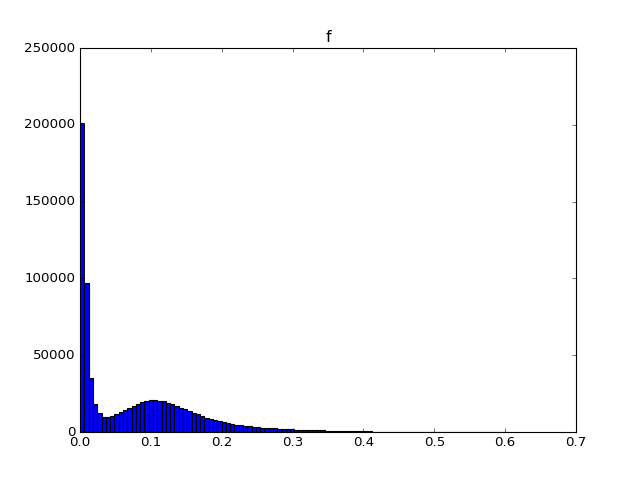

In [7]:
print 'Max and min f:',np.max(frac_para_error),np.min(frac_para_error)
print 'Number above 0.1:',np.where(frac_para_error>0.1)[0].shape[0]

%matplotlib notebook
plt.hist(frac_para_error,bins=100)
plt.title('f')
plt.show()

### Computing distance and FWHM:
Gaia parallaxes have a zero-point shift of -0.029 mas.  So 0.029 mas must be added to the measured parallax to get accurate distances.  (Luri et. al. 2018 (https://arxiv.org/abs/1804.09376))<br>
Also, the parallax must be converted to arcseconds to get the distance in parcsecs.

In [162]:
start = time.time()

omega,sigma = (gparallax+0.029)/1000,gparaerror/1000
gdist = np.array([])

print 'Computing distances'
count=0
for i in range(len(omega)):
    coeff = np.array([(1./L),(-2),((omega[i])/((sigma[i])**2)),-(1./((sigma[i])**2))])
    g = np.roots(coeff)
    # Find the number of real roots:
    reals = np.isreal(g)
    realsum = np.sum(reals)
    # If there is one real root, that root is the  mode:
    if realsum == 1:
        gd = np.real(g[np.where(reals)[0]])
    # If all roots are real:
    elif realsum == 3:
        if omega[i] >= 0:
            # Take the smallest root:
            gd = np.min(g)
        elif omega[i] < 0:
            # Take the positive root (there should be only one):
            gd = g[np.where(g>0)[0]]
    gdist = np.append(gdist,gd)
    
    count = count+1
    mod=count%100000
    if mod==0:
        print 'Finished ',count,' sources'
print 'Finished distances for ',gdist.shape[0]

end = time.time()
print(end - start)

print 'Computing FWHM'

count=0
rmax = 1e6
fwhm_lo,fwhm_hi = np.array([]),np.array([])
for i in range(len(omega)):
    rmode = gdist[i]
    M = (rmode**2*np.exp(-rmode/L)/sigma[i])*np.exp((-1./(2*(sigma[i])**2))*(omega[i]-(1./rmode))**2)
    lo = brentq(lambda x: 2*np.log(x)-(x/L)-(((omega[i]-(1./x))**2)/(2*sigma[i]**2)) \
               +np.log(2)-np.log(M)-np.log(sigma[i]), 0.001, rmode)
    hi = brentq(lambda x: 2*np.log(x)-(x/L)-(((omega[i]-(1./x))**2)/(2*sigma[i]**2)) \
               +np.log(2)-np.log(M)-np.log(sigma[i]), rmode, rmax)
    fwhm_lo,fwhm_hi = np.append(fwhm_lo,lo),np.append(fwhm_hi,hi)
    
    count = count+1
    mod=count%100000
    if mod==0:
        print 'Finished ',count,' sources'

print 'Finished FWHM for ',fwhm_lo.shape[0]
end = time.time()
print(end - start)

Computing distances
Finished  100000  sources
Finished  200000  sources
Finished  300000  sources
Finished  400000  sources
Finished  500000  sources
Finished  600000  sources
Finished  700000  sources
Finished  800000  sources
Finished distances for  847549
1059.87764001
Computing FWHM
Finished  100000  sources
Finished  200000  sources
Finished  300000  sources
Finished  400000  sources
Finished  500000  sources
Finished  600000  sources
Finished  700000  sources
Finished  800000  sources
Finished FWHM for  847549
3257.66336489


In [167]:
print np.where(gdist>=2000)[0].shape

(5637,)


<IPython.core.display.Javascript object>


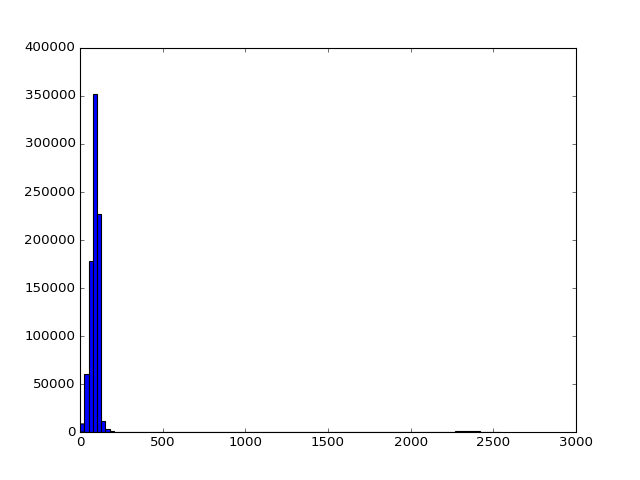

In [168]:
%matplotlib notebook
plt.hist(gdist,bins=100)
plt.show()

In [208]:
# Make new columns in dataframe and populate with new data:
m['dist'],m['dist_fwhm_lo'],m['dist_fwhm_hi'] = pd.Series(gdist, index=m.index),\
    pd.Series(fwhm_lo, index=m.index),pd.Series(fwhm_hi, index=m.index)
m

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,dist,dist_fwhm_lo,dist_fwhm_hi
0,1635721458409799680,Gaia DR2 5853498713160606720,5853498713160606720,521085047,2015.5,217.393466,0.057653,-62.676182,0.104971,768.500365,...,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,1.301187,1.300782,1.301591
1,1635721458409799680,Gaia DR2 1824801659879180544,1824801659879180544,1636241798,2015.5,297.367581,1.605905,20.039360,0.940170,739.280660,...,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,1.352647,1.347071,1.358269
2,1635721458409799680,Gaia DR2 5978137354097288064,5978137354097288064,69132276,2015.5,256.526344,1.296829,-34.471846,0.909087,675.107965,...,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,1.481217,1.475196,1.487287
3,1635721458409799680,Gaia DR2 4145394651996744704,4145394651996744704,1631745869,2015.5,269.293391,1.469097,-15.491524,2.011990,674.936986,...,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,1.481606,1.474513,1.488767
4,1635721458409799680,Gaia DR2 4090109764196360576,4090109764196360576,183178470,2015.5,277.630076,2.863634,-21.542353,1.772632,672.414860,...,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,1.487171,1.479503,1.494919
5,1635721458409799680,Gaia DR2 4043588155928790528,4043588155928790528,1422236868,2015.5,268.767764,0.895659,-32.086910,0.957212,656.014043,...,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,1.524298,1.521388,1.527220
6,1635721458409799680,Gaia DR2 4046472106243728128,4046472106243728128,1606081479,2015.5,275.389947,1.297960,-30.317141,1.854956,655.612427,...,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,1.525279,1.517701,1.532933
7,1635721458409799680,Gaia DR2 4147859001074741888,4147859001074741888,56736782,2015.5,267.527808,1.621941,-16.370345,0.782909,652.702353,...,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,1.532043,1.527565,1.536547
8,1635721458409799680,Gaia DR2 4049336059085668608,4049336059085668608,1109120141,2015.5,274.579977,0.866917,-30.907785,1.130792,650.651011,...,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,1.536876,1.532000,1.541783
9,1635721458409799680,Gaia DR2 4119879724447178624,4119879724447178624,605484864,2015.5,266.158948,1.694173,-19.706950,2.119982,648.954328,...,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,1.540921,1.533669,1.548243


In [209]:
print gdist[847545],frac_para_error[847545]
print gdist[847546],frac_para_error[847546]

2269.03804451 0.383615446525
111.408820076 0.0126339023805


All of the sources with distance >2000 pc have large f values, greater than 0.3.  We should likely eliminate them later when looking for closest stars.

(19327,)
(76790,)
[ 0.37011105  0.38774147  0.36852245 ...,  0.37799622  0.39277669
  0.38361545]


<IPython.core.display.Javascript object>


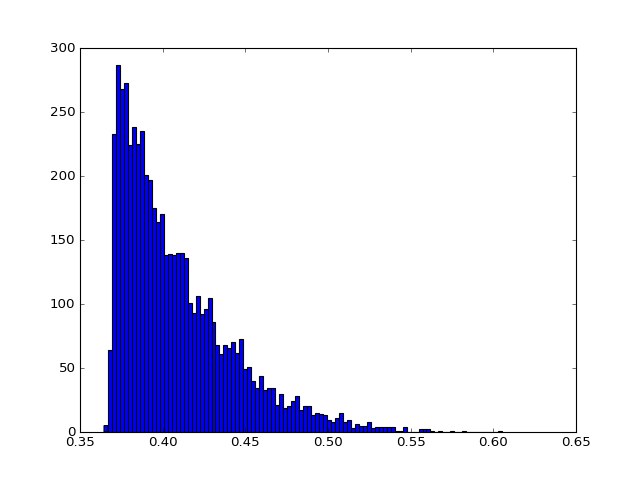

In [210]:
print np.where(frac_para_error>=0.3)[0].shape
print np.where(frac_para_error>=0.2)[0].shape
print frac_para_error[np.where(gdist>=2000)[0]]
%matplotlib notebook
plt.hist(frac_para_error[np.where(gdist>=2000)[0]],bins=100)
plt.show()

### Eliminate the >2000 pc sources:

In [211]:
print np.where(gdist>2000)[0].shape
print np.where(m['dist'].values>2000)[0].shape

(5637,)
(5637,)


In [212]:
n=m.drop(np.where(m['dist'].values>2000)[0],axis=0)
n=n.reset_index()
n = n.drop(['index'], axis=1)
n

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,dist,dist_fwhm_lo,dist_fwhm_hi
0,1635721458409799680,Gaia DR2 5853498713160606720,5853498713160606720,521085047,2015.5,217.393466,0.057653,-62.676182,0.104971,768.500365,...,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,1.301187,1.300782,1.301591
1,1635721458409799680,Gaia DR2 1824801659879180544,1824801659879180544,1636241798,2015.5,297.367581,1.605905,20.039360,0.940170,739.280660,...,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,1.352647,1.347071,1.358269
2,1635721458409799680,Gaia DR2 5978137354097288064,5978137354097288064,69132276,2015.5,256.526344,1.296829,-34.471846,0.909087,675.107965,...,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,1.481217,1.475196,1.487287
3,1635721458409799680,Gaia DR2 4145394651996744704,4145394651996744704,1631745869,2015.5,269.293391,1.469097,-15.491524,2.011990,674.936986,...,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,1.481606,1.474513,1.488767
4,1635721458409799680,Gaia DR2 4090109764196360576,4090109764196360576,183178470,2015.5,277.630076,2.863634,-21.542353,1.772632,672.414860,...,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,1.487171,1.479503,1.494919
5,1635721458409799680,Gaia DR2 4043588155928790528,4043588155928790528,1422236868,2015.5,268.767764,0.895659,-32.086910,0.957212,656.014043,...,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,1.524298,1.521388,1.527220
6,1635721458409799680,Gaia DR2 4046472106243728128,4046472106243728128,1606081479,2015.5,275.389947,1.297960,-30.317141,1.854956,655.612427,...,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,1.525279,1.517701,1.532933
7,1635721458409799680,Gaia DR2 4147859001074741888,4147859001074741888,56736782,2015.5,267.527808,1.621941,-16.370345,0.782909,652.702353,...,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,1.532043,1.527565,1.536547
8,1635721458409799680,Gaia DR2 4049336059085668608,4049336059085668608,1109120141,2015.5,274.579977,0.866917,-30.907785,1.130792,650.651011,...,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,1.536876,1.532000,1.541783
9,1635721458409799680,Gaia DR2 4119879724447178624,4119879724447178624,605484864,2015.5,266.158948,1.694173,-19.706950,2.119982,648.954328,...,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,1.540921,1.533669,1.548243


Histogram of distances less than 2000 pc:

<IPython.core.display.Javascript object>


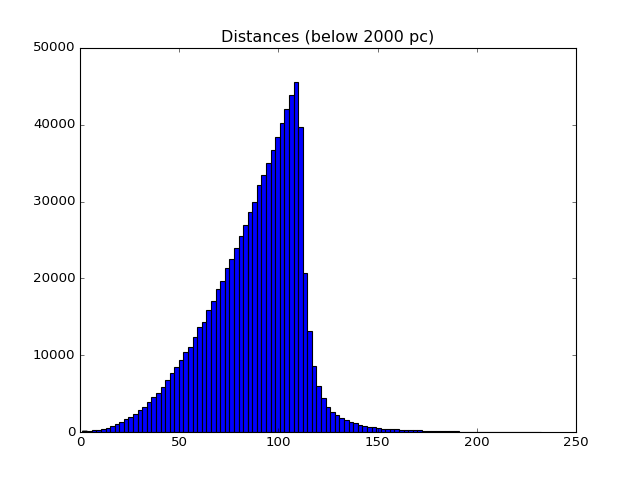

In [213]:
%matplotlib notebook
plt.hist(n['dist'],bins=100)
plt.title('Distances (below 2000 pc)')
plt.show()

In [192]:
print np.min(n['parallax'])

8.94966556929


## Get more to fill out to 1M:

In [193]:
start = time.time()
job = Gaia.launch_job_async(query="SELECT TOP 200000 * FROM gaiadr2.gaia_source WHERE parallax < 8.94966556929 \
                    ORDER BY parallax DESC",\
                    verbose=False, dump_to_file=True, output_format='csv')
print job

end = time.time()
print(end - start)

Jobid: 1530043616450O
Phase: COMPLETED
Owner: None
Output file: async_20180626130658.csv
Results: None
805.795394897


In [214]:
k = pd.read_csv('async_20180626130658.csv')

print np.where(np.isnan(k['bp_rp'].values))[0].shape

(29616,)


In [215]:
# Drop sources without G mag info:
m=k.drop(np.where(np.isnan(k['bp_rp'].values))[0],axis=0)
m=m.reset_index()
print np.where(np.isnan(m['bp_rp'].values))[0].shape
m = m.drop(['index'], axis=1)
m

(0,)


,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url
0,1635721458409799680,Gaia DR2 334324446209239424,334324446209239424,704175722,2015.5,40.496069,0.224063,39.209084,0.157953,8.949661,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN
1,1635721458409799680,Gaia DR2 1896348835665006592,1896348835665006592,1639852432,2015.5,328.867562,0.345013,28.724538,0.397764,8.949657,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN
2,1635721458409799680,Gaia DR2 424353974423028224,424353974423028224,1189178689,2015.5,13.895457,0.376428,58.008482,0.443868,8.949657,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN
3,1635721458409799680,Gaia DR2 2887964257832593664,2887964257832593664,413313581,2015.5,85.706400,0.095312,-36.658085,0.104049,8.949649,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN
4,1635721458409799680,Gaia DR2 5900131097216240640,5900131097216240640,1067324097,2015.5,224.105693,0.826605,-52.237229,0.821880,8.949642,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN
5,1635721458409799680,Gaia DR2 2047094632921795328,2047094632921795328,1280639117,2015.5,296.299837,1.387540,34.468191,1.305737,8.949640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN
6,1635721458409799680,Gaia DR2 4115482266271174784,4115482266271174784,355147303,2015.5,256.920740,1.849614,-22.262770,1.656454,8.949638,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN
7,1635721458409799680,Gaia DR2 4169411421825200000,4169411421825200000,1478969303,2015.5,264.029815,1.275933,-7.080464,1.282151,8.949629,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN
8,1635721458409799680,Gaia DR2 2007278121428073472,2007278121428073472,430688291,2015.5,340.268760,0.727932,57.308669,0.581958,8.949628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN
9,1635721458409799680,Gaia DR2 1760084680302323328,1760084680302323328,153219669,2015.5,315.624850,0.473477,14.207522,0.445310,8.949626,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN


In [216]:
# Compute distance:
gaia_id = m['source_id'].values
gra,gdec = m['ra'].values,m['dec'].values
gpmra,gpmde = m['pmra'].values,m['pmdec'].values
ggmag,gbpflux,grpflux = m['phot_g_mean_mag'].values,m['phot_bp_mean_flux'].values,m['phot_rp_mean_flux'].values
gbpmag,grpmag,gbprpmag = m['phot_bp_mean_mag'].values,m['phot_rp_mean_mag'].values,m['bp_rp'].values
gparallax,gparaerror = m['parallax'].values,m['parallax_error'].values
#l,b,ecl_lon,ecl_lat,radius,rv = k['l'].values,k['b'].values,k['ecl_lon'].values,k['ecl_lat'].values,\
#    k['radius_val'].values,k['radial_velocity'].values
#teff,lum,color = k['teff_val'].values,k['lum_val'].values,k['astrometric_pseudo_colour'].values

frac_para_error = gparaerror/gparallax
omega,sigma = gparallax/1000,gparaerror/1000

In [217]:
start = time.time()

omega,sigma = (gparallax+0.029)/1000,gparaerror/1000
gdist = np.array([])

print 'Computing distances'
count=0
for i in range(len(omega)):
    coeff = np.array([(1./L),(-2),((omega[i])/((sigma[i])**2)),-(1./((sigma[i])**2))])
    g = np.roots(coeff)
    # Find the number of real roots:
    reals = np.isreal(g)
    realsum = np.sum(reals)
    # If there is one real root, that root is the  mode:
    if realsum == 1:
        gd = np.real(g[np.where(reals)[0]])
    # If all roots are real:
    elif realsum == 3:
        if omega[i] >= 0:
            # Take the smallest root:
            gd = np.min(g)
        elif omega[i] < 0:
            # Take the positive root (there should be only one):
            gd = g[np.where(g>0)[0]]
    gdist = np.append(gdist,gd)
    
    count = count+1
    mod=count%50000
    if mod==0:
        print 'Finished ',count,' sources'
print 'Finished distances for ',gdist.shape[0]

end = time.time()
print(end - start)

print 'Computing FWHM'

count=0
rmax = 1e6
fwhm_lo,fwhm_hi = np.array([]),np.array([])
for i in range(len(omega)):
    rmode = gdist[i]
    M = (rmode**2*np.exp(-rmode/L)/sigma[i])*np.exp((-1./(2*(sigma[i])**2))*(omega[i]-(1./rmode))**2)
    lo = brentq(lambda x: 2*np.log(x)-(x/L)-(((omega[i]-(1./x))**2)/(2*sigma[i]**2)) \
               +np.log(2)-np.log(M)-np.log(sigma[i]), 0.001, rmode)
    hi = brentq(lambda x: 2*np.log(x)-(x/L)-(((omega[i]-(1./x))**2)/(2*sigma[i]**2)) \
               +np.log(2)-np.log(M)-np.log(sigma[i]), rmode, rmax)
    fwhm_lo,fwhm_hi = np.append(fwhm_lo,lo),np.append(fwhm_hi,hi)
    
    count = count+1
    mod=count%50000
    if mod==0:
        print 'Finished ',count,' sources'

print 'Finished FWHM for ',fwhm_lo.shape[0]
end = time.time()
print(end - start)

Computing distances
Finished  50000  sources
Finished  100000  sources
Finished  150000  sources
Finished distances for  170384
47.6253421307
Computing FWHM
Finished  50000  sources
Finished  100000  sources
Finished  150000  sources
Finished FWHM for  170384
169.178291082


In [219]:
# Make new columns in dataframe and populate with new data:
m['dist'],m['dist_fwhm_lo'],m['dist_fwhm_hi'] = pd.Series(gdist, index=m.index),\
    pd.Series(fwhm_lo, index=m.index),pd.Series(fwhm_hi, index=m.index)
m

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,dist,dist_fwhm_lo,dist_fwhm_hi
0,1635721458409799680,Gaia DR2 334324446209239424,334324446209239424,704175722,2015.5,40.496069,0.224063,39.209084,0.157953,8.949661,...,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,111.540813,107.997106,115.325085
1,1635721458409799680,Gaia DR2 1896348835665006592,1896348835665006592,1639852432,2015.5,328.867562,0.345013,28.724538,0.397764,8.949657,...,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,112.064736,105.017945,120.127443
2,1635721458409799680,Gaia DR2 424353974423028224,424353974423028224,1189178689,2015.5,13.895457,0.376428,58.008482,0.443868,8.949657,...,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,112.736628,102.997768,124.518819
3,1635721458409799680,Gaia DR2 2887964257832593664,2887964257832593664,413313581,2015.5,85.706400,0.095312,-36.658085,0.104049,8.949649,...,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,111.411422,109.731728,113.143343
4,1635721458409799680,Gaia DR2 5900131097216240640,5900131097216240640,1067324097,2015.5,224.105693,0.826605,-52.237229,0.821880,8.949642,...,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,115.042337,99.461558,136.494791
5,1635721458409799680,Gaia DR2 2047094632921795328,2047094632921795328,1280639117,2015.5,296.299837,1.387540,34.468191,1.305737,8.949640,...,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,119.756916,96.478818,158.466338
6,1635721458409799680,Gaia DR2 4115482266271174784,4115482266271174784,355147303,2015.5,256.920740,1.849614,-22.262770,1.656454,8.949638,...,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,129.228486,94.670082,209.333517
7,1635721458409799680,Gaia DR2 4169411421825200000,4169411421825200000,1478969303,2015.5,264.029815,1.275933,-7.080464,1.282151,8.949629,...,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,120.659148,96.156785,162.739930
8,1635721458409799680,Gaia DR2 2007278121428073472,2007278121428073472,430688291,2015.5,340.268760,0.727932,57.308669,0.581958,8.949628,...,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,113.245844,101.925986,127.412691
9,1635721458409799680,Gaia DR2 1760084680302323328,1760084680302323328,153219669,2015.5,315.624850,0.473477,14.207522,0.445310,8.949626,...,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,112.527650,103.530435,123.244002


In [220]:
mm=m.drop(np.where(m['dist'].values>2000)[0],axis=0)
mm=mm.reset_index()
mm = mm.drop(['index'], axis=1)

### Put them together:

In [383]:
final = pd.concat([mm,n],ignore_index = True)
#final

In [384]:
# Add column for fractional parallax error:
# (Which is really just the inverse of the column "parallax_over_error")
gparallax,gparaerror = final['parallax'].values,final['parallax_error'].values
frac = gparaerror/gparallax
final['frac_para_error'] = pd.Series(frac, index=final.index)

# Sort by distance:
final = final.sort_values(by=['dist'])
final=final.reset_index()
final = final.drop(['index'], axis=1)
#final = final.drop(['level_0'], axis=1)

# Keep the top 1M results:
final = final.loc[:999999]

final

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,dist,dist_fwhm_lo,dist_fwhm_hi,frac_para_error
0,1635721458409799680,Gaia DR2 5853498713160606720,5853498713160606720,521085047,2015.5,217.393466,0.057653,-62.676182,0.104971,768.500365,...,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,1.301187,1.300782,1.301591,0.000264
1,1635721458409799680,Gaia DR2 1824801659879180544,1824801659879180544,1636241798,2015.5,297.367581,1.605905,20.039360,0.940170,739.280660,...,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,1.352647,1.347071,1.358269,0.003515
2,1635721458409799680,Gaia DR2 5978137354097288064,5978137354097288064,69132276,2015.5,256.526344,1.296829,-34.471846,0.909087,675.107965,...,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,1.481217,1.475196,1.487287,0.003466
3,1635721458409799680,Gaia DR2 4145394651996744704,4145394651996744704,1631745869,2015.5,269.293391,1.469097,-15.491524,2.011990,674.936986,...,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,1.481606,1.474513,1.488767,0.004085
4,1635721458409799680,Gaia DR2 4090109764196360576,4090109764196360576,183178470,2015.5,277.630076,2.863634,-21.542353,1.772632,672.414860,...,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,1.487171,1.479503,1.494919,0.004402
5,1635721458409799680,Gaia DR2 4043588155928790528,4043588155928790528,1422236868,2015.5,268.767764,0.895659,-32.086910,0.957212,656.014043,...,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,1.524298,1.521388,1.527220,0.001625
6,1635721458409799680,Gaia DR2 4046472106243728128,4046472106243728128,1606081479,2015.5,275.389947,1.297960,-30.317141,1.854956,655.612427,...,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,1.525279,1.517701,1.532933,0.004241
7,1635721458409799680,Gaia DR2 4147859001074741888,4147859001074741888,56736782,2015.5,267.527808,1.621941,-16.370345,0.782909,652.702353,...,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,1.532043,1.527565,1.536547,0.002490
8,1635721458409799680,Gaia DR2 4049336059085668608,4049336059085668608,1109120141,2015.5,274.579977,0.866917,-30.907785,1.130792,650.651011,...,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,1.536876,1.532000,1.541783,0.002703
9,1635721458409799680,Gaia DR2 4119879724447178624,4119879724447178624,605484864,2015.5,266.158948,1.694173,-19.706950,2.119982,648.954328,...,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,1.540921,1.533669,1.548243,0.004016


In [ ]:
# Write it out!
final.to_csv('Nearest_1M_stars.csv')

In [ ]:
final = pd.read_csv('Nearest_1M_stars.csv')
final

### Compute uncertainty on the distance.

As demonstrated elsewhere, for sources with f <~ 0.1, you can approximate the poterior distance distribution as gaussian, so we can use sigma=FWHM/2.355 to approximate the std dev.  This means the 95% CI is ~ +/- 2*sigma

For f larger than 0.1, the 95% CI has to be estimated with an MCMC.  Which is computationalls intensive.  In this sample, ~380,000 sources have f>.1:

In [49]:
print np.where(final['frac_para_error']<0.1)[0].shape
print np.where(final['frac_para_error']>0.1)[0].shape

(618209,)
(381791,)


In [374]:
# Make new columns for 95% CI:
sl,sh = pd.Series('NaN', index=final.index),\
    pd.Series('NaN', index=final.index)

In [50]:
print np.where(final['frac_para_error']<0.10)[0].shape
ind = np.where(final['frac_para_error']<0.10)[0]
ddist = final['dist'].values[ind]
ddist_sigma = (final['dist_fwhm_hi'].values[ind]-final['dist_fwhm_lo'].values[ind])/2.355
dist_95ci_lo = ddist-2*ddist_sigma
dist_95ci_hi = ddist+2*ddist_sigma
print dist_95ci_lo.shape
count=0
#for i in ind:
#    count=count+1
#    final.loc[[i],'dist_95ci_lo']= dist_95ci_lo[i]
#    final.loc[[i],'dist_95ci_hi']= dist_95ci_hi[i]
#    mod=count%10000
#    if mod==0:
#        print 'Finished ',count
#final

(618209,)
(618209,)


#### MCMC time

In [ ]:
def prob(r):
    p = (r**2*np.exp(-r/L)/(sigma[0]))*np.exp((-1/(2*(sigma[0])**2))*(omega[0]-(1/r))**2)
    if not np.isfinite(p):
        return -np.inf 
    return p

def sampler(lnprob,mu_init=0,proposal_width=0.5,nsamples=50,prob=[0.05, 0.5, 0.95]):
    from scipy.stats import norm
    mu_current = mu_init
    posterior = [mu_current]
    yes_accept = 0
    for i in range(nsamples):
        mu_proposal = norm(mu_current,proposal_width).rvs()
        prob_of_proposal = lnprob(mu_proposal)
        prob_current = lnprob(mu_current)
        p_accept = prob_of_proposal/prob_current
        dice = np.random.rand()
        accept = dice < p_accept
        if accept:
            mu_current = mu_proposal
            yes_accept = yes_accept+1 #for tracking acceptance rate
        posterior.append(mu_current)
    return posterior,mquantiles(posterior, prob=prob),np.float(yes_accept)/np.float(nsamples)

In [51]:
# Pull out relevant rows:
ind = np.where(final['frac_para_error']>0.10)[0]
mu_init = final['dist'].values[ind]
posterior,dist_95ci_lo,dist_95ci_hi = np.zeros(len(mu_init)),np.zeros(len(mu_init)),np.zeros(len(mu_init))
count = 0

#for i in ind:
#    post,quant,accept_rate = sampler(prob,mu_init=mu_init[i],nsamples=1000,proposal_width=1.0)
    

In [52]:
ind = np.where(final['frac_para_error']>0.1)[0]
print ind.shape
print ind[0]

(381791,)
4643


### A better way.

So I could execute this cell this way.  To get 10,000 samples takes about 5-10 s per source.  Times 380,000 sources, that is 527 hours.  Unmanageable.  A better way is to use paralla processing.

I wrote a parallel process code called "gaia_distance_error_mcmc.py".  It splits up the source list and divides the tasks among the processor cores.  Each core only gets a chunk of the list to run the mcmc on.  I have some time on the Texas Advanced Computing Center (TACC) supercomputer Lonestar 5, which has 48 cores.  380,000/48 with 5 seconds per run takes about 11 hours.  Totally doable!

Make a new dataframe of just the sources with f>0.1 and write out to csv:

In [54]:
out = final.filter(['parallax','parallax_error','dist'], axis=1)
out = out.loc[ind]
out['index'] = pd.Series(ind, index=out.index)
out.to_csv('input_to_mcmc.csv')
#out

#### Demonstration of f=0.1 cut:

4.62596210957 30.5809882948 34.292441161
0.151269215533
2 sigma of gaussian approx 5.8013510896


<IPython.core.display.Javascript object>


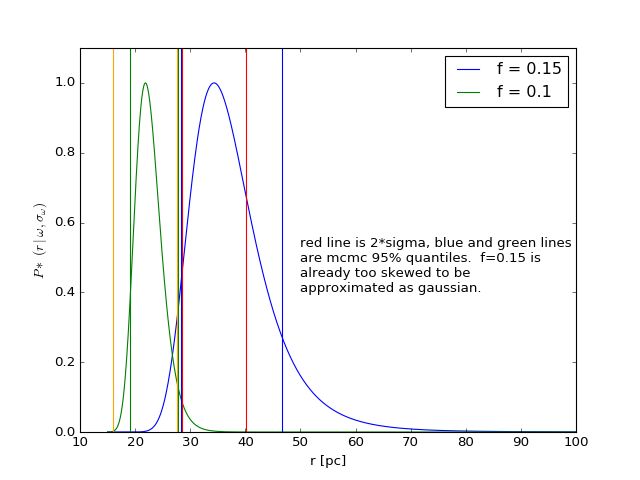

In [66]:
print final['parallax_error'].values[17712],final['parallax'].values[17712],final['dist'].values[17712]
print final['parallax_error'].values[17712]/final['parallax'].values[17712]
print '2 sigma of gaussian approx',(final['dist_fwhm_hi'].values[17712]-final['dist_fwhm_lo'].values[17712])/2.355
twosigma = (final['dist_fwhm_hi'].values[17712]-final['dist_fwhm_lo'].values[17712])/2.355
twosigma2 = (final['dist_fwhm_hi'].values[4643]-final['dist_fwhm_lo'].values[4643])/2.355
L=1350
r = np.linspace(15,100,1e3-1)

post = (r**2*np.exp(-r/L)/final['parallax_error'].values[4643]/1000)*\
    np.exp((-1/(2*(final['parallax_error'].values[17712]/1000)**2))*(final['parallax'].values[17712]/1000-(1/r))**2)
post2 = (r**2*np.exp(-r/L)/final['parallax_error'].values[4643]/1000)*\
    np.exp((-1/(2*(final['parallax_error'].values[4643]/1000)**2))*(final['parallax'].values[4643]/1000-(1/r))**2)

%matplotlib notebook
plt.plot(r,post/np.max(post),label='f = {0}'.format(0.15))
plt.plot(r,post2/np.max(post2),label='f = {0}'.format(0.1),color='green')
plt.axvline(x=28.4)
plt.axvline(x=46.688)
plt.axvline(x=19.02,color='green')
plt.axvline(x=27.858,color='green')
plt.axvline(x=final['dist'].values[17712]+twosigma,color='red')
plt.axvline(x=final['dist'].values[17712]-twosigma,color='red')
plt.axvline(x=final['dist'].values[4643]+twosigma,color='orange')
plt.axvline(x=final['dist'].values[4643]-twosigma,color='orange')
plt.annotate('red line is 2*sigma, blue and green lines \nare mcmc 95% quantiles.  f=0.15 is \nalready too skewed to be\
    \napproximated as gaussian.',xy=(50,0.4),xytext=(50,0.4))
plt.ylim(0,1.1)
plt.legend()
plt.ylabel('$P*\;(r \mid \omega , \sigma_{\omega})$')
plt.xlabel('r [pc]')
plt.show()

# Properties of the sample:

<IPython.core.display.Javascript object>


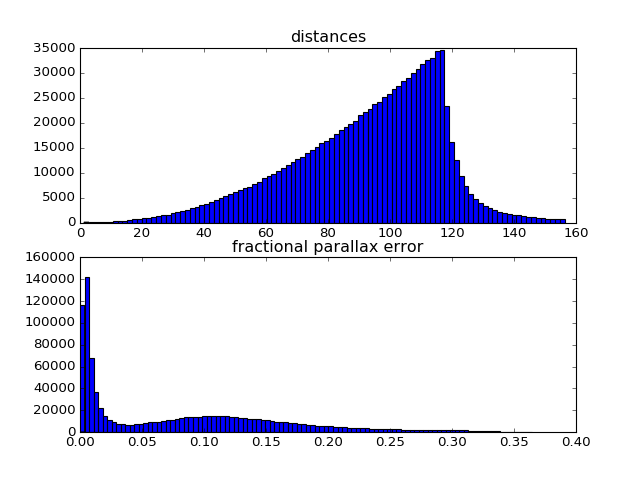

In [256]:
# Histogram of the distances:
%matplotlib notebook
plt.subplot(211)
plt.title('distances')
plt.hist(final['dist'].values,bins=100)
plt.subplot(212)
plt.title('fractional parallax error')
plt.hist(final['frac_para_error'].values,bins=100)
plt.show()

### Maps

<IPython.core.display.Javascript object>


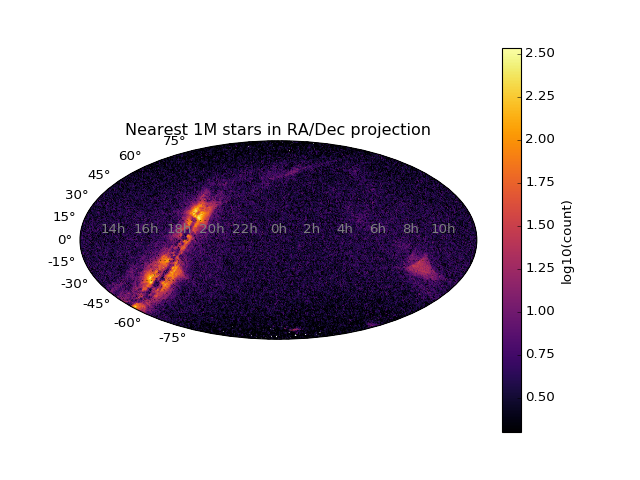

In [322]:
# Prefix p for plotting to distinguish these objects from the ones in the table:
import astropy.coordinates as coord
# First make Astropy coordinate objects:
pra = coord.Angle(final['ra'].values*u.degree)
pra = pra.wrap_at(180*u.degree)
pdec = coord.Angle(final['dec'].values*u.degree)

%matplotlib notebook
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
hb = ax.hexbin(pra.radian, pdec.radian,gridsize=500,cmap='inferno',bins='log',mincnt=1)
#ax.scatter(pra.radian, pdec.radian,alpha=0.2,color='blue',s=5)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'],color='grey')
ax.set_title('Nearest 1M stars in RA/Dec projection')
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(count)')
ax.grid(True)
plt.show()
#plt.savefig('nearest_1M_radec_mollweide.eps', dpi=300, format='eps')

<IPython.core.display.Javascript object>


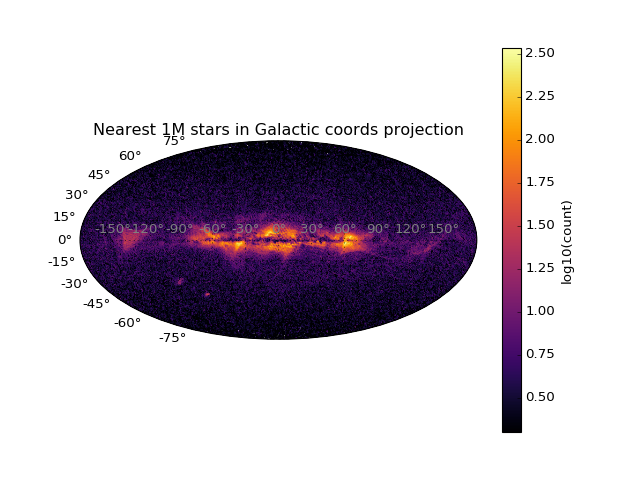

In [323]:
pl = coord.Angle(final['l'].values*u.degree)
pl = pl.wrap_at(180*u.degree)
pb = coord.Angle(final['b'].values*u.degree)

%matplotlib notebook
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
ax.hexbin(pl.radian, pb.radian,gridsize=500,cmap='inferno',bins='log',mincnt=1)
#ax.scatter(pra.radian, pdec.radian,alpha=0.2,color='blue',s=5)
#ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.set_title('Nearest 1M stars in Galactic coords projection')
ax.tick_params(axis='x', colors='grey')
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(count)')
ax.grid(True)
plt.show()
#plt.savefig('nearest_1M_gal_mollweide.jpg', dpi=300, format='jpg')

### CMD

In [267]:
# GBP - GRP color:
color = final['bp_rp'].values
# Apparent G band magnitude:
gmag = final['phot_g_mean_mag'].values 

# Convert to absolute magnitude (excluding extinction for now):
GMag = gmag + 5 + 5*np.log10(final['parallax'].values/1000)

20.5288 15.2177011407
8.953612 13.3818323915
4.42822039146 -5.31109885926


<IPython.core.display.Javascript object>


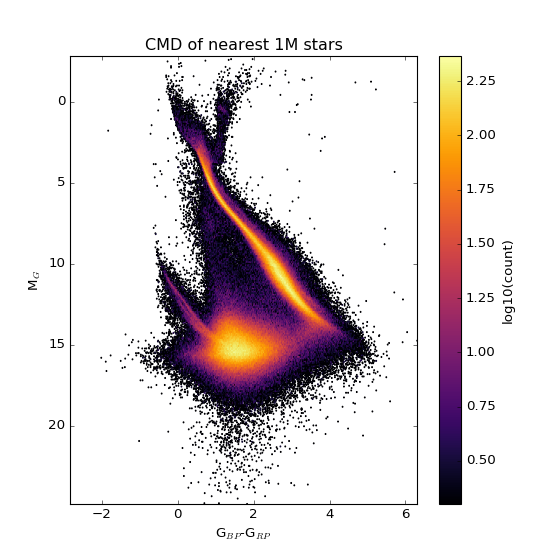

In [289]:
%matplotlib notebook
fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(7, 7))
#fig.subplots_adjust(hspace=0.5, left=0.07, right=0.93)

#ax = axs[0]
hb = ax.hexbin(color,GMag,gridsize=500,cmap='inferno',bins='log',mincnt=1)
ax.set_title("CMD of nearest 1M stars")
ax.set_ylabel('M$_{G}$')
ax.set_xlabel('G$_{BP}$-G$_{RP}$')
ax.invert_yaxis()
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(count)')

plt.show()
plt.savefig('nearest_1M_cmd.eps', dpi=300, format='eps')

<IPython.core.display.Javascript object>


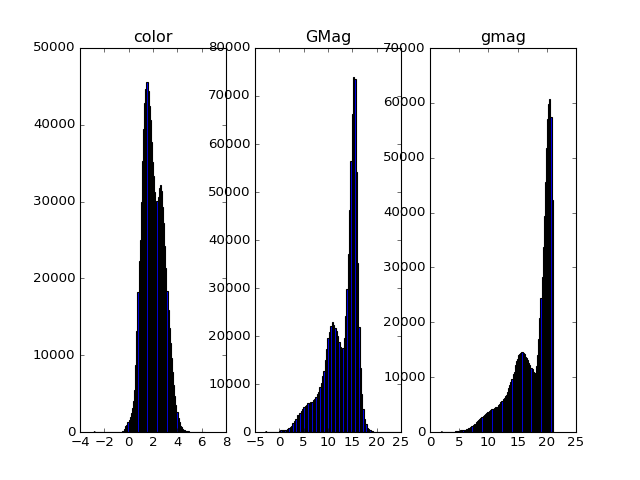

In [310]:
%matplotlib notebook
plt.subplot(131)
plt.title('color')
plt.hist(color,bins=100)
plt.subplot(132)
plt.title('GMag')
plt.hist(GMag,bins=100)
plt.subplot(133)
plt.title('gmag')
plt.hist(gmag,bins=100)
plt.show()

(193698,)
Percent w/ 15<GMag<16 with sig noise: 0.799869508841
(9480,)
Percent w/ 0<GMag<5 with sig noise: 0.272554769708



<IPython.core.display.Javascript object>


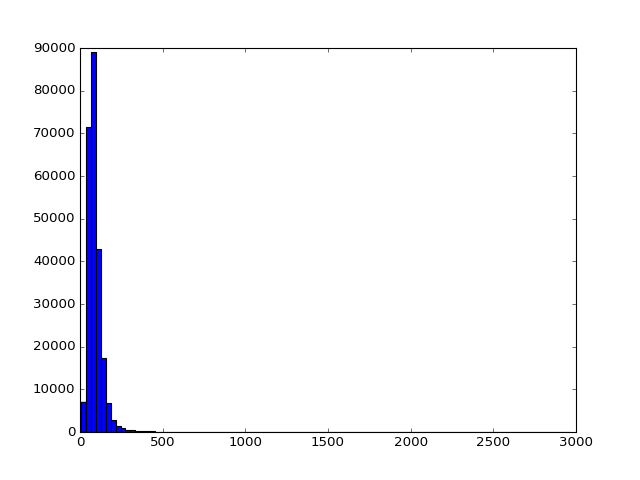

In [321]:
#print np.where((GMag<16)&(GMag>15))[0].shape[0]
#print final['astrometric_excess_noise_sig'].values[np.where((GMag<16)&(GMag>15))[0]]
D1 = final['astrometric_excess_noise_sig'].values[np.where((GMag<16)&(GMag>15))[0]]
print np.where(D1>=2)[0].shape
print 'Percent w/ 15<GMag<16 with sig noise:',float(np.where(D1>=2)[0].shape[0])/float(D1.shape[0])
D2 = final['astrometric_excess_noise_sig'].values[np.where((GMag<5)&(GMag>0))[0]]
print np.where(D2>=2)[0].shape
print 'Percent w/ 0<GMag<5 with sig noise:',float(np.where(D2>=2)[0].shape[0])/float(D2.shape[0])
print ''
%matplotlib notebook
plt.hist(final['phot_g_mean_flux_over_error'].values[np.where((GMag<16)&(GMag>15))[0]],bins=100)
plt.show()

What if I apply the cuts from the Gaia HRD paper:

In [325]:
# Cut: parallax over error better than 20% (the HRD paper uses 10% conservatively)
o=final.drop(np.where(final['parallax_over_error'].values>20)[0],axis=0)
o=o.reset_index()
o = o.drop(['index'], axis=1)
print o.shape

(539220, 100)


<IPython.core.display.Javascript object>


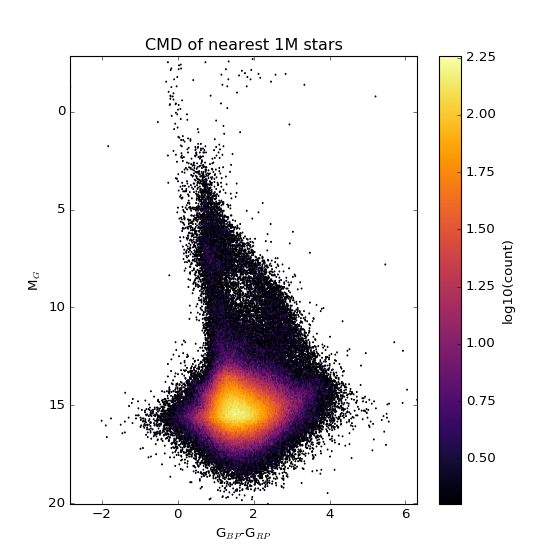

In [326]:
# GBP - GRP color:
color = o['bp_rp'].values
# Apparent G band magnitude:
gmag = o['phot_g_mean_mag'].values 
# Convert to absolute magnitude (excluding extinction for now):
GMag = gmag + 5 + 5*np.log10(o['parallax'].values/1000)
%matplotlib notebook
fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(7, 7))
hb = ax.hexbin(color,GMag,gridsize=500,cmap='inferno',bins='log',mincnt=1)
ax.set_title("CMD of nearest 1M stars")
ax.set_ylabel('M$_{G}$')
ax.set_xlabel('G$_{BP}$-G$_{RP}$')
ax.invert_yaxis()
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(count)')
plt.show()

So I accidentally did this wrong and dropped all the sources with para_over_error more than 20, when I needed to drop para_over_error less than 20.  Because a higher number means better parallax solution.

But look - we've isolated the problem area.  So this is looking promising.  Doing the right thing:

In [329]:
# Cut: parallax over error better than 20% (the HRD paper uses 10% conservatively)
o=final.drop(np.where(final['parallax_over_error'].values<20)[0],axis=0)
o=o.reset_index()
o = o.drop(['index'], axis=1)
print o.shape

(460780, 100)


<IPython.core.display.Javascript object>


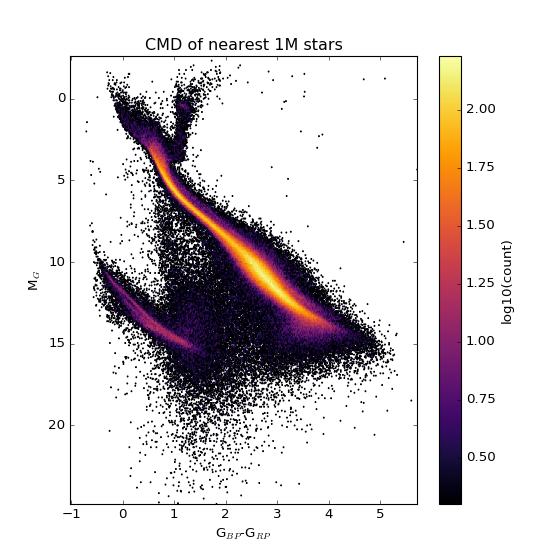

In [330]:
# GBP - GRP color:
color = o['bp_rp'].values
# Apparent G band magnitude:
gmag = o['phot_g_mean_mag'].values 
# Convert to absolute magnitude (excluding extinction for now):
GMag = gmag + 5 + 5*np.log10(o['parallax'].values/1000)
%matplotlib notebook
fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(7, 7))
hb = ax.hexbin(color,GMag,gridsize=500,cmap='inferno',bins='log',mincnt=1)
ax.set_title("CMD of nearest 1M stars")
ax.set_ylabel('M$_{G}$')
ax.set_xlabel('G$_{BP}$-G$_{RP}$')
ax.invert_yaxis()
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(count)')
plt.show()

Yep that removed the problem for the most part.

Let's try other cuts.

(473770, 100)


<IPython.core.display.Javascript object>


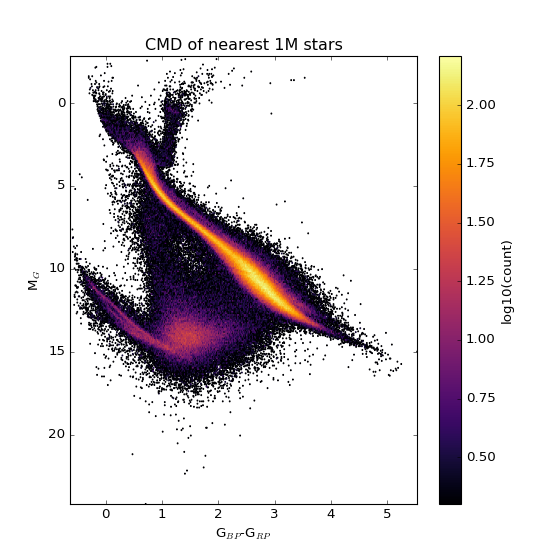

In [336]:
# Cut: drop mean g flux over error less than 50 - this encapsulates large errors in the g mag term
o=final.drop(np.where(final['phot_g_mean_flux_over_error'].values<50)[0],axis=0)
o=o.reset_index()
o=o.drop(['index'], axis=1)
o=o.drop(np.where(o['phot_rp_mean_flux_over_error'].values<20)[0],axis=0)
o=o.reset_index()
o=o.drop(['index'], axis=1)
o=o.drop(np.where(o['phot_bp_mean_flux_over_error'].values<20)[0],axis=0)
o=o.reset_index()
o = o.drop(['index'], axis=1)
print o.shape

# GBP - GRP color:
color = o['bp_rp'].values
# Apparent G band magnitude:
gmag = o['phot_g_mean_mag'].values 
# Convert to absolute magnitude (excluding extinction for now):
GMag = gmag + 5 + 5*np.log10(o['parallax'].values/1000)
%matplotlib notebook
fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(7, 7))
hb = ax.hexbin(color,GMag,gridsize=500,cmap='inferno',bins='log',mincnt=1)
ax.set_title("CMD of nearest 1M stars")
ax.set_ylabel('M$_{G}$')
ax.set_xlabel('G$_{BP}$-G$_{RP}$')
ax.invert_yaxis()
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(count)')
plt.show()

So that did a decent job (but I still see some hanging out in the (2,15) area.)

(891513, 100)


<IPython.core.display.Javascript object>


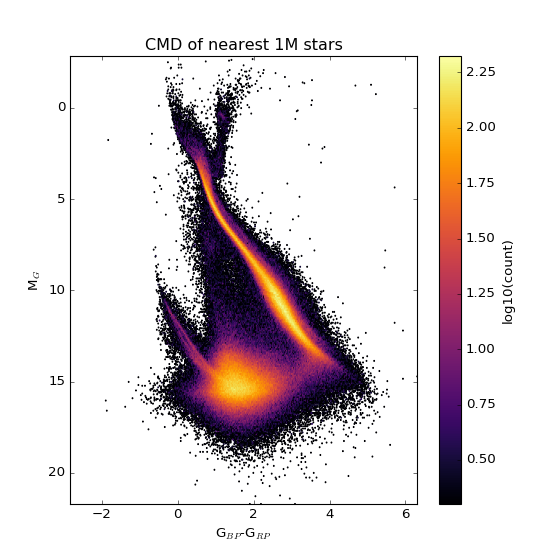

In [337]:
#Cut: use sources with only a large number of visibility periods (higher N -> lower uncert), more than 8
o=final.drop(np.where(final['visibility_periods_used'].values<8)[0],axis=0)
o=o.reset_index()
o=o.drop(['index'], axis=1)
print o.shape

# GBP - GRP color:
color = o['bp_rp'].values
# Apparent G band magnitude:
gmag = o['phot_g_mean_mag'].values 
# Convert to absolute magnitude (excluding extinction for now):
GMag = gmag + 5 + 5*np.log10(o['parallax'].values/1000)
%matplotlib notebook
fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(7, 7))
hb = ax.hexbin(color,GMag,gridsize=500,cmap='inferno',bins='log',mincnt=1)
ax.set_title("CMD of nearest 1M stars")
ax.set_ylabel('M$_{G}$')
ax.set_xlabel('G$_{BP}$-G$_{RP}$')
ax.invert_yaxis()
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(count)')
plt.show()

Didn't make much difference

In [340]:
# Cut: The chi2 criterion of Lindegren+ 2018
v1 = np.sqrt(final['astrometric_chi2_al'].values/(final['astrometric_n_good_obs_al'].values-5))
v2=np.zeros(len(v1))
for i in range(len(v1)):
    v2[i] = 1.2*max(1,np.exp(-0.2*(final['phot_g_mean_mag'].values[i]-19.5)))
print v2

[ 9.89074189  1.2         1.2        ...,  1.2         1.2         1.2       ]


In [342]:
print np.where(v2<v1)[0].shape

(499904,)


(500096, 100)


<IPython.core.display.Javascript object>


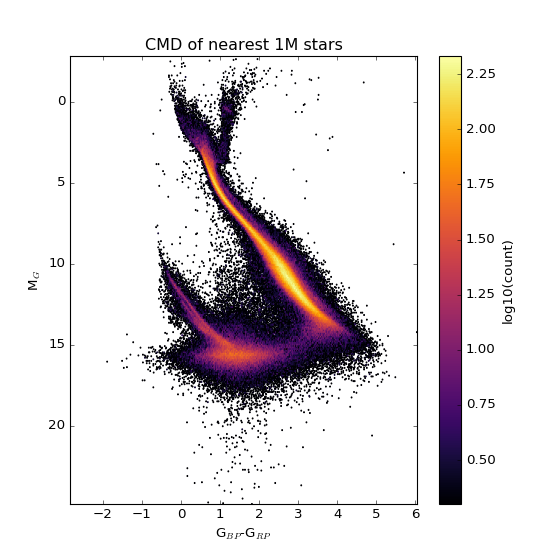

In [344]:
o=final.drop(np.where(v2<v1)[0],axis=0)
o=o.reset_index()
o=o.drop(['index'], axis=1)
print o.shape

# GBP - GRP color:
color = o['bp_rp'].values
# Apparent G band magnitude:
gmag = o['phot_g_mean_mag'].values 
# Convert to absolute magnitude (excluding extinction for now):
GMag = gmag + 5 + 5*np.log10(o['parallax'].values/1000)
%matplotlib notebook
fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(7, 7))
hb = ax.hexbin(color,GMag,gridsize=500,cmap='inferno',bins='log',mincnt=1)
ax.set_title("CMD of nearest 1M stars")
ax.set_ylabel('M$_{G}$')
ax.set_xlabel('G$_{BP}$-G$_{RP}$')
ax.invert_yaxis()
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(count)')
plt.show()

Also good, but not as good as the parallax quality.